In [1]:
import pandas as pd

df = pd.read_parquet(path='./../data/dataset_site_info.parquet')
df = df[df['tier'] == 'AODSIM']


In [2]:
from cmSim.utils import get_mcm_data

mcm_data = get_mcm_data(filepath='./../data/zip_mcm_dump.json')


Reading zipped json file... Done


In [3]:
from cmSim.utils import assign_pwg_to_dataset, merge_pwgs_in_dataframe

df['pwg'] = df['dataset_name'].apply(assign_pwg_to_dataset, mcm_data=mcm_data)
df = merge_pwgs_in_dataframe(df)

df.head(None)


,dataset_name,dataset_id,replica_time_create,node_name,rep_size,min_time,max_time,br_user_group_id,tier,pwg
2,/GluGluToContinToZZTo2mu2nu_13TeV_MCFM701_pyth...,1114967,20200113,T2_FI_HIP,2.060427e+11,2020-01-14,2020-04-29,42.0,AODSIM,HIG
3,/WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphM...,1247050,20200323,T2_US_Caltech,1.034198e+13,2020-03-23,2020-05-05,22.0,AODSIM,SUS
5,/SMS-T2bt-LLChipm_ctau-200_mLSP-1400_TuneCUETP...,1397254,20190925,T2_DE_DESY,1.866242e+11,2019-09-26,2020-12-31,22.0,AODSIM,SUS
7,/DYJetsToMuMu_M-50_TuneCP5_14TeV-madgraphMLM-p...,1560259,20200524,T1_RU_JINR_Disk,1.618496e+12,2020-06-06,2020-09-29,18.0,AODSIM,TRK
8,/DYJetsToTauTau_ForcedMuDecay_M-50_TuneCP5_13T...,1106693,20181003,T2_FR_IPHC,5.941757e+11,2019-01-01,2019-02-13,42.0,AODSIM,HIG
...,...,...,...,...,...,...,...,...,...,...
1268205,/GluGluHToWWToLNuQQ_M140_NNPDF31_TuneCP5_PSwei...,1353747,20190611,T2_FR_IPHC,4.005138e+09,2019-06-12,2019-06-26,18.0,AODSIM,HIG
1268206,/ggZH_HToGG_ZToNuNu_M125_13TeV_powheg_pythia8_...,1307530,20190402,T1_US_FNAL_Disk,1.705961e+09,2019-04-03,2019-04-09,18.0,AODSIM,HIG
1268207,/ST_tW_top_5f_NoFullyHadronicDecays_13TeV_PSwe...,1332017,20190506,T2_BE_UCL,5.500226e+08,2019-05-06,2019-07-12,18.0,AODSIM,TOP
1268208,/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_T...,1573739,20200724,T2_US_Wisconsin,8.395474e+10,2020-09-30,2020-10-01,NaN,AODSIM,EGM


In [4]:
from cmSim.utils import get_pags

pags = list(get_pags())
pags.append('None')
print(pags)


['BPH', 'SUS', 'TOP', 'B2G', 'HIG', 'SMP', 'EXO', 'HIN', 'None']


In [5]:
from cmSim.utils import get_countries

countries = list(get_countries())
print(countries)


['Greece', 'Portugal', 'Germany', 'Turkey', 'China', 'Italy', 'Finland', 'Belgium', 'Pakistan', 'India', 'France', 'Ukraine', 'United Kingdom', 'Poland', 'Austria', 'Estonia', 'Switzerland', 'Russia', 'Taiwan', 'Malaysia', 'Hungary', 'Spain', 'South Korea', 'USA', 'Brazil', 'Thailand']


In [6]:
from cmSim.utils import get_country_by_site

df['country'] = df['node_name'].apply(get_country_by_site)

df.head(None)


,dataset_name,dataset_id,replica_time_create,node_name,rep_size,min_time,max_time,br_user_group_id,tier,pwg,country
2,/GluGluToContinToZZTo2mu2nu_13TeV_MCFM701_pyth...,1114967,20200113,T2_FI_HIP,2.060427e+11,2020-01-14,2020-04-29,42.0,AODSIM,HIG,Finland
3,/WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphM...,1247050,20200323,T2_US_Caltech,1.034198e+13,2020-03-23,2020-05-05,22.0,AODSIM,SUS,USA
5,/SMS-T2bt-LLChipm_ctau-200_mLSP-1400_TuneCUETP...,1397254,20190925,T2_DE_DESY,1.866242e+11,2019-09-26,2020-12-31,22.0,AODSIM,SUS,Germany
7,/DYJetsToMuMu_M-50_TuneCP5_14TeV-madgraphMLM-p...,1560259,20200524,T1_RU_JINR_Disk,1.618496e+12,2020-06-06,2020-09-29,18.0,AODSIM,TRK,Russia
8,/DYJetsToTauTau_ForcedMuDecay_M-50_TuneCP5_13T...,1106693,20181003,T2_FR_IPHC,5.941757e+11,2019-01-01,2019-02-13,42.0,AODSIM,HIG,France
...,...,...,...,...,...,...,...,...,...,...,...
1268205,/GluGluHToWWToLNuQQ_M140_NNPDF31_TuneCP5_PSwei...,1353747,20190611,T2_FR_IPHC,4.005138e+09,2019-06-12,2019-06-26,18.0,AODSIM,HIG,France
1268206,/ggZH_HToGG_ZToNuNu_M125_13TeV_powheg_pythia8_...,1307530,20190402,T1_US_FNAL_Disk,1.705961e+09,2019-04-03,2019-04-09,18.0,AODSIM,HIG,USA
1268207,/ST_tW_top_5f_NoFullyHadronicDecays_13TeV_PSwe...,1332017,20190506,T2_BE_UCL,5.500226e+08,2019-05-06,2019-07-12,18.0,AODSIM,TOP,Belgium
1268208,/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_T...,1573739,20200724,T2_US_Wisconsin,8.395474e+10,2020-09-30,2020-10-01,NaN,AODSIM,EGM,USA


In [7]:
from datetime import date

df = df[df['pwg'].isin(pags)]

date = date(2020, 12, 31)
df_date = df[(df['min_time'] <= date) & (date <= df['max_time'])]


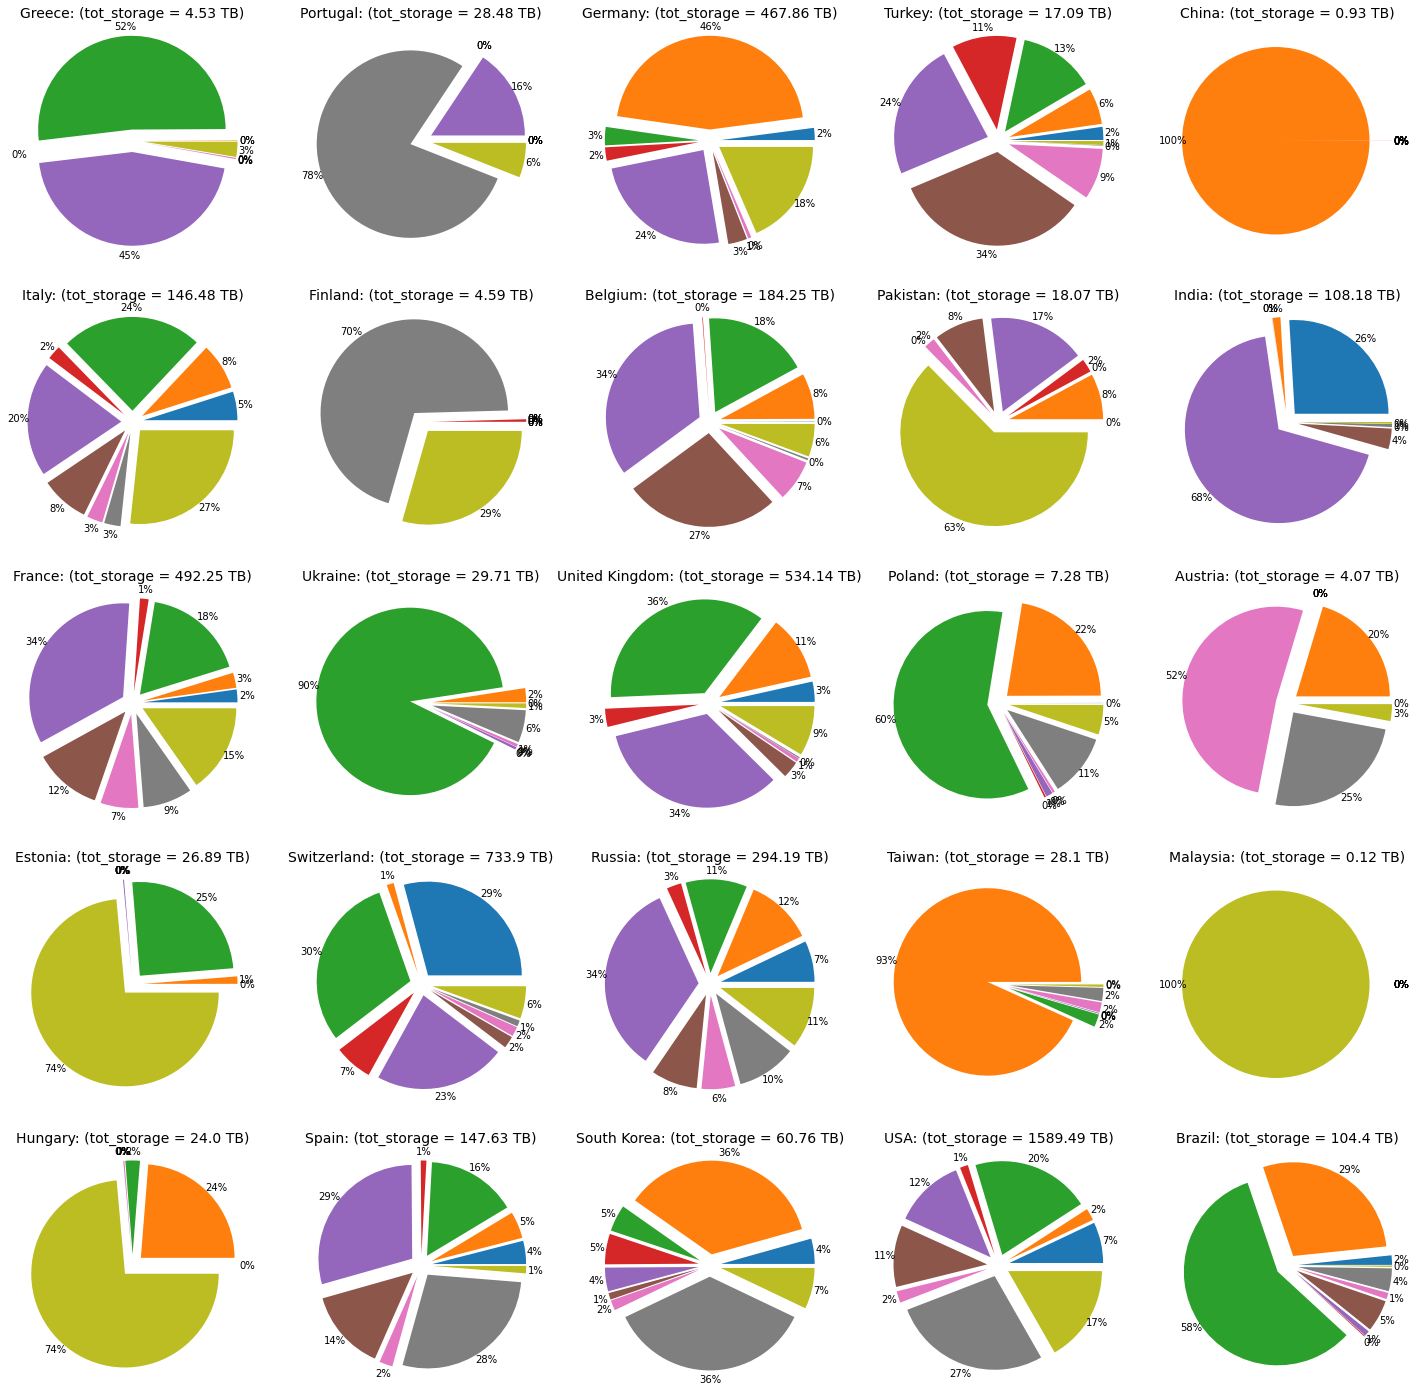

In [8]:
import pylab as plt

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
axs = axs.ravel()

i = 0
for country in countries:
    df_date_country = df_date[df_date['country'] == country]
    tot_size = round(df_date_country['rep_size'].sum()/1e12, 2)
    data = [df_date_country[df_date_country['pwg'] == pag]
            ['rep_size'].sum()
            for pag in pags]
    if tot_size > 0.:
        patches, _, _ = axs[i].pie(data, explode=[0.12]*len(data), autopct='%1.0f%%',
                                   pctdistance=1.1, textprops={'fontsize': 10}, normalize=True)
        title = f'{country}: (tot_storage = {tot_size} TB)'
        axs[i].set_title(title, fontsize=14)
        i += 1


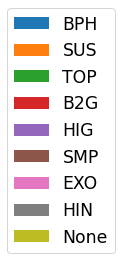

In [9]:
fig, ax = plt.subplots(figsize=(1, 1))
plt.axis('off')

fig.legend(patches, pags, fontsize='xx-large')
